In [ ]:
!git clone https://github.com/ganeshmm/TamilNet.git

Cloning into 'TamilNet'...
remote: Enumerating objects: 83829, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 83829 (delta 42), reused 72 (delta 21), pack-reused 83717 (from 1)
Receiving objects: 100% (83829/83829), 92.25 MiB | 9.03 MiB/s, done.
Resolving deltas: 100% (1065/1065), done.
Updating files: 100% (238185/238185), done.


In [ ]:
ls TamilNet/data/processed/train


0/    108/  118/  128/  138/  148/  18/  28/  38/  48/  58/  68/  78/  88/  98/
1/    109/  119/  129/  139/  149/  19/  29/  39/  49/  59/  69/  79/  89/  99/
10/   11/   12/   13/   14/   15/   2/   3/   4/   5/   6/   7/   8/   9/
100/  110/  120/  130/  140/  150/  20/  30/  40/  50/  60/  70/  80/  90/
101/  111/  121/  131/  141/  151/  21/  31/  41/  51/  61/  71/  81/  91/
102/  112/  122/  132/  142/  152/  22/  32/  42/  52/  62/  72/  82/  92/
103/  113/  123/  133/  143/  153/  23/  33/  43/  53/  63/  73/  83/  93/
104/  114/  124/  134/  144/  154/  24/  34/  44/  54/  64/  74/  84/  94/
105/  115/  125/  135/  145/  155/  25/  35/  45/  55/  65/  75/  85/  95/
106/  116/  126/  136/  146/  16/   26/  36/  46/  56/  66/  76/  86/  96/
107/  117/  127/  137/  147/  17/   27/  37/  47/  57/  67/  77/  87/  97/


In [ ]:
from PIL import Image, ImageOps, ImageFilter
import numpy as np
from scipy import ndimage
from torchvision import datasets, transforms
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# Check for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Preprocessing Class
class Process(object):
    def __call__(self, img):
        converted = img.convert("L")
        inverted = ImageOps.invert(converted)
        thick = inverted.filter(ImageFilter.MaxFilter(5))
        ratio = 48.0 / max(thick.size)
        new_size = tuple([int(round(x*ratio)) for x in thick.size])
        res = thick.resize(new_size, Image.LANCZOS)

        arr = np.asarray(res)
        com = ndimage.measurements.center_of_mass(arr)
        result = Image.new("L", (64, 64))
        box = (int(round(32.0 - com[1])), int(round(32.0 - com[0])))
        result.paste(res, box)
        return result

In [ ]:
from torchvision import datasets
import matplotlib.pyplot as plt

train_dir = "TamilNet/data/processed/train"
training_set = datasets.ImageFolder(train_dir)

# Get one image from 5 different classes
class_samples = {}
for img, label in training_set:
    if label not in class_samples:
        class_samples[label] = (img, training_set.classes[label])
    if len(class_samples) == 5:
        break

sample_imgs = [val[0] for val in class_samples.values()]
sample_labels = [val[1] for val in class_samples.values()]


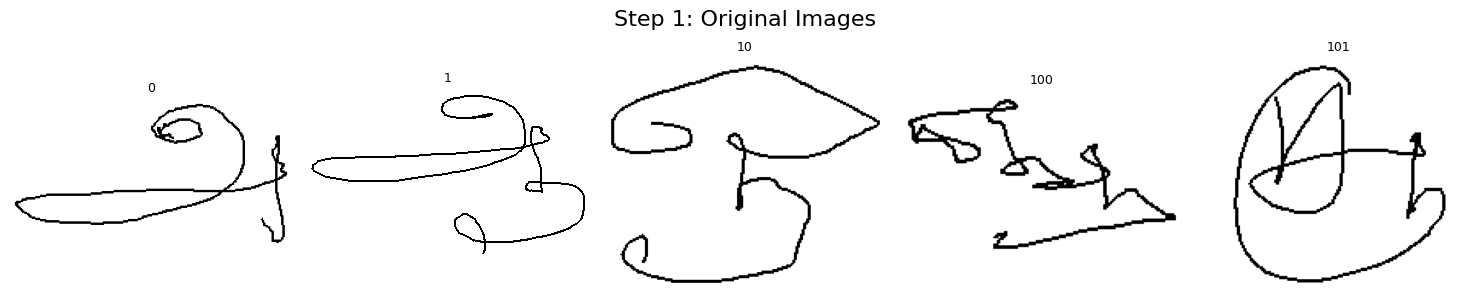

In [ ]:
def show_images(images, title):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    for i, img in enumerate(images):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"{sample_labels[i]}", fontsize=9)
    plt.tight_layout()
    plt.show()

show_images(sample_imgs, "Step 1: Original Images")


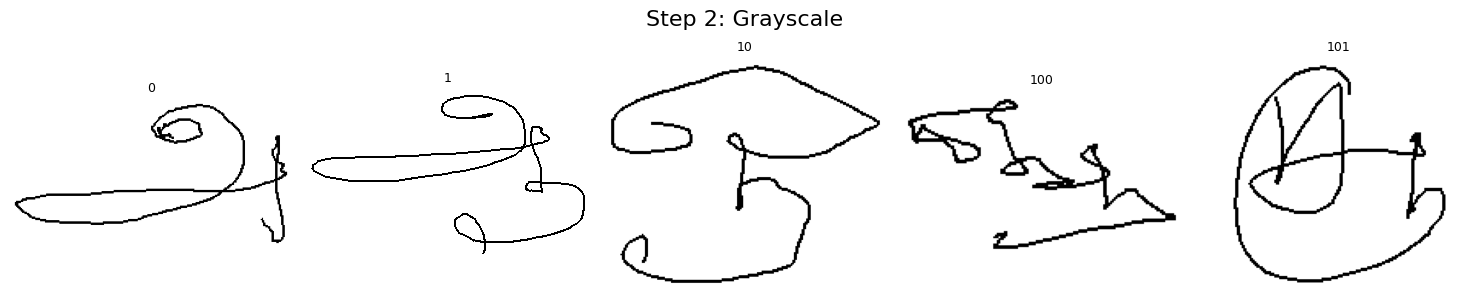

In [ ]:
grayscale_imgs = [img.convert("L") for img in sample_imgs]
show_images(grayscale_imgs, "Step 2: Grayscale")


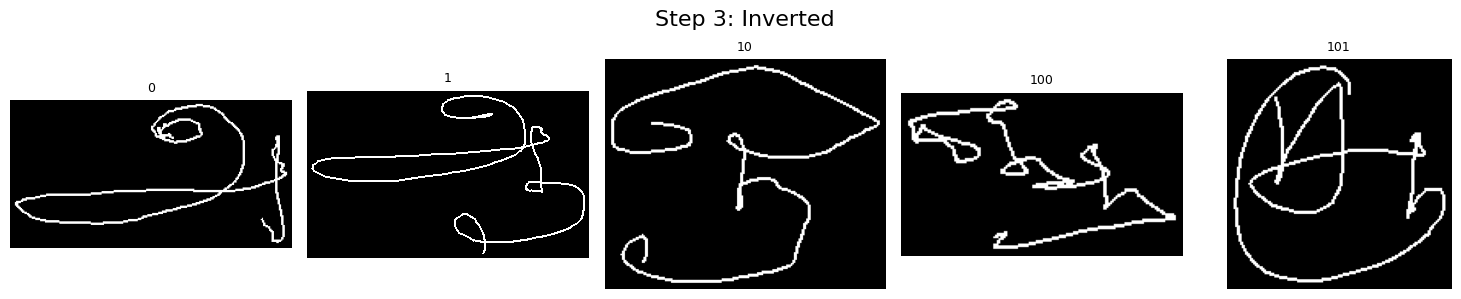

In [ ]:
from PIL import ImageOps

inverted_imgs = [ImageOps.invert(img) for img in grayscale_imgs]
show_images(inverted_imgs, "Step 3: Inverted")


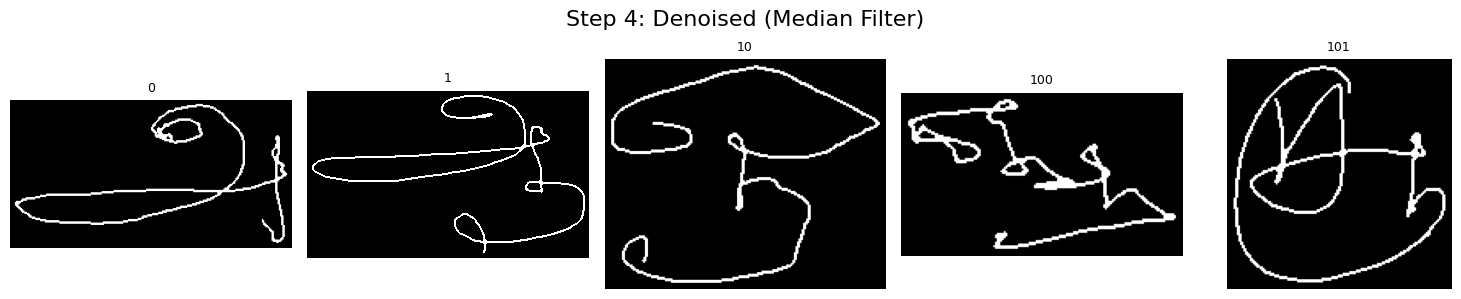

In [ ]:
from PIL import ImageFilter

denoised_imgs = [img.filter(ImageFilter.MedianFilter(size=3)) for img in inverted_imgs]
show_images(denoised_imgs, "Step 4: Denoised (Median Filter)")


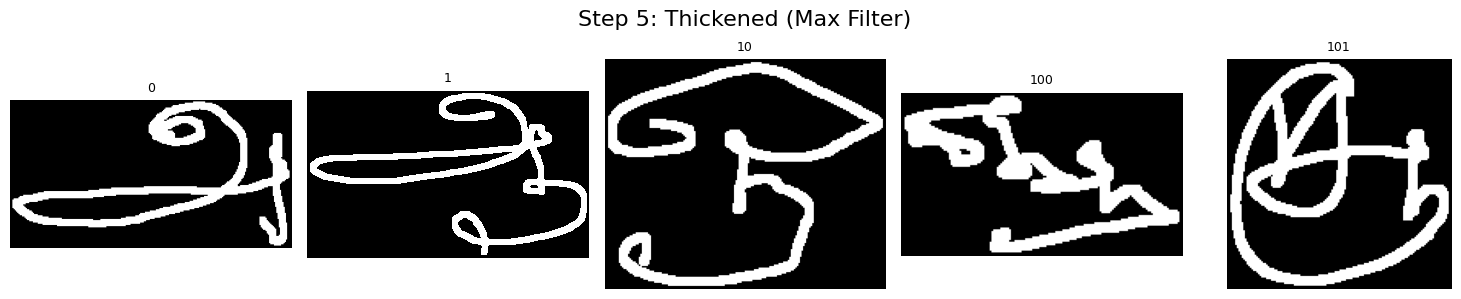

In [ ]:
thickened_imgs = [img.filter(ImageFilter.MaxFilter(5)) for img in denoised_imgs]
show_images(thickened_imgs, "Step 5: Thickened (Max Filter)")


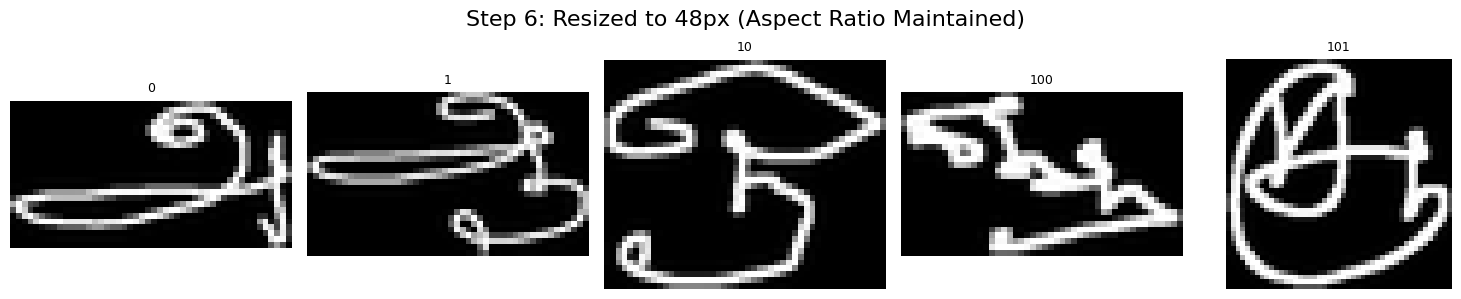

In [ ]:
resized_imgs = []
for img in thickened_imgs:
    ratio = 48.0 / max(img.size)
    new_size = tuple([int(round(x * ratio)) for x in img.size])
    resized_imgs.append(img.resize(new_size, Image.LANCZOS))

show_images(resized_imgs, "Step 6: Resized to 48px (Aspect Ratio Maintained)")


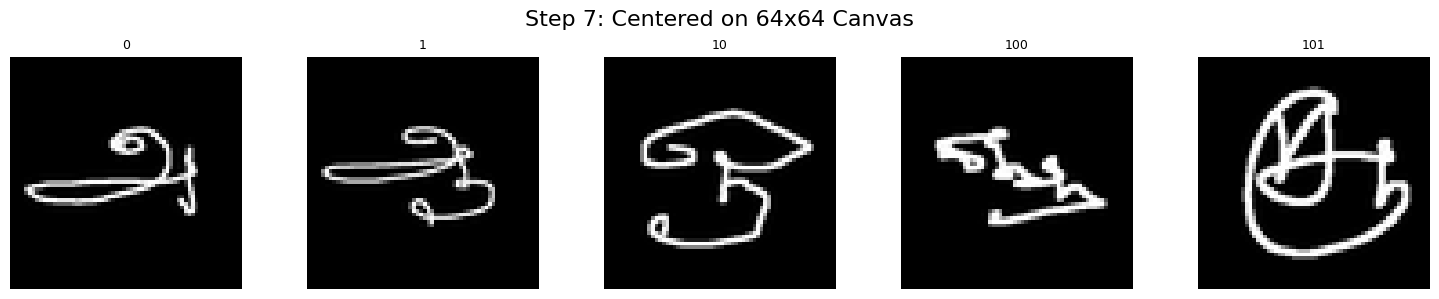

In [ ]:
import numpy as np
from scipy import ndimage
from PIL import Image

centered_imgs = []
for img in resized_imgs:
    arr = np.asarray(img)
    com = ndimage.center_of_mass(arr)
    result = Image.new("L", (64, 64))
    box = (int(round(32.0 - com[1])), int(round(32.0 - com[0])))
    result.paste(img, box)
    centered_imgs.append(result)

show_images(centered_imgs, "Step 7: Centered on 64x64 Canvas")


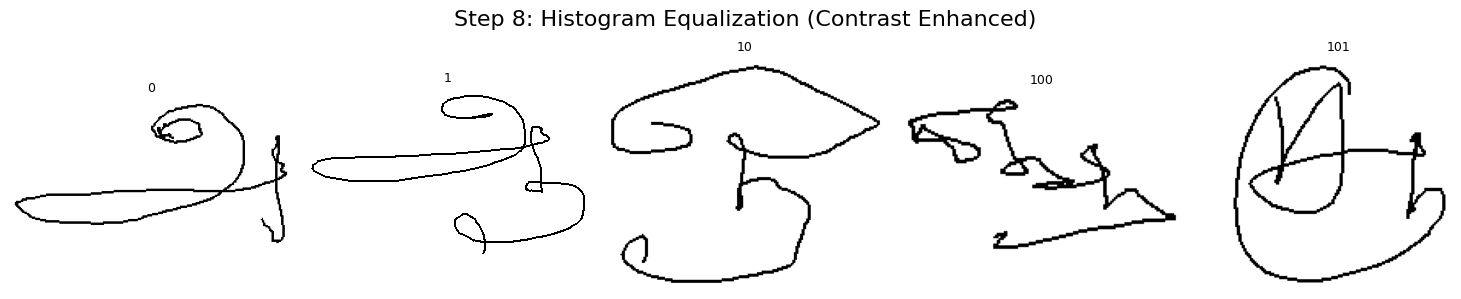

In [ ]:
import cv2

# Apply histogram equalization using OpenCV
equalized_imgs = []
for img in grayscale_imgs:
    np_img = np.array(img)
    eq_img = cv2.equalizeHist(np_img)
    equalized_imgs.append(Image.fromarray(eq_img))

show_images(equalized_imgs, "Step 8: Histogram Equalization (Contrast Enhanced)")


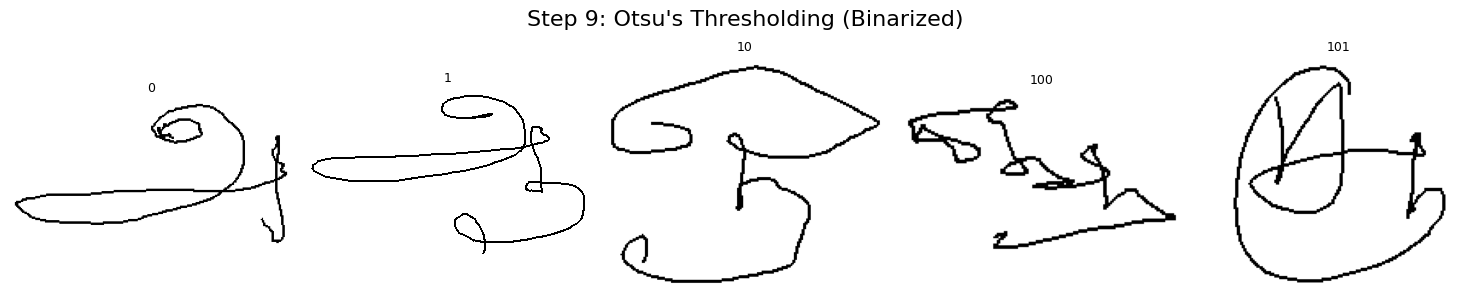

In [ ]:
binarized_imgs = []
for img in equalized_imgs:
    np_img = np.array(img)
    _, bin_img = cv2.threshold(np_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binarized_imgs.append(Image.fromarray(bin_img))

show_images(binarized_imgs, "Step 9: Otsu's Thresholding (Binarized)")


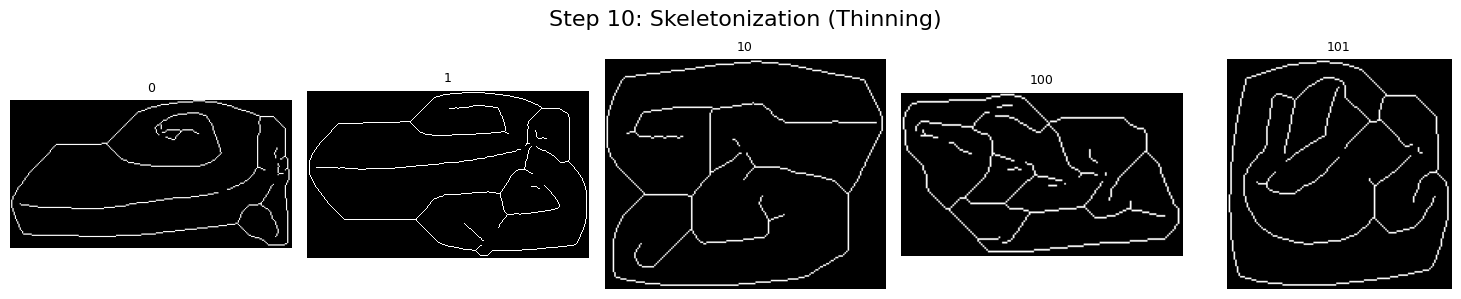

In [ ]:
from skimage.morphology import skeletonize
from skimage.util import invert

skeleton_imgs = []
for img in binarized_imgs:
    np_img = np.array(img)
    # Convert to binary: foreground=1, background=0
    binary = np_img > 0
    skeleton = skeletonize(binary)  # returns a boolean array
    skeleton_uint8 = (skeleton * 255).astype(np.uint8)
    skeleton_imgs.append(Image.fromarray(skeleton_uint8))

show_images(skeleton_imgs, "Step 10: Skeletonization (Thinning)")


In [ ]:
# Define Transformations
transform = transforms.Compose([Process(), transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])


In [ ]:
#"TamilNet\data\unprocessed\train"
train_dir = "TamilNet/data/processed/train"
test_dir ="TamilNet/data/processed/test"


In [ ]:
# Load Dataset
training_set = datasets.ImageFolder(train_dir, transform)
trainsize = int(round(0.8 * len(training_set)))
trainset, valset = torch.utils.data.random_split(training_set, [trainsize, len(training_set) - trainsize], generator=torch.Generator().manual_seed(42))
testset = datasets.ImageFolder(test_dir, transform)

# Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [ ]:
# Load Tamil Unicode CSV
df = pd.read_csv("TamilNet/data/TamilChar.csv", header=0)
unicode_list = df["Unicode"].tolist()
char_list = []
for element in unicode_list:
    code_list = element.split()
    chars_together = "".join([chr(int("0x" + code, 16)) for code in code_list])
    char_list.append(chars_together)

In [ ]:
# Map Class Indices to Tamil Characters
classes = [char_list[int(testset.classes[i])] for i in range(156)]
print(classes)

['அ', 'ஆ', 'ஓ', 'ஙூ', 'சூ', 'ஞூ', 'டூ', 'ணூ', 'தூ', 'நூ', 'பூ', 'மூ', 'யூ', 'ஃ', 'ரூ', 'லூ', 'வூ', 'ழூ', 'ளூ', 'றூ', 'னூ', 'ா', 'ெ', 'ே', 'க', 'ை', 'ஸ்ரீ', 'ஸு', 'ஷு', 'ஜு', 'ஹு', 'க்ஷு', 'ஸூ', 'ஷூ', 'ஜூ', 'ங', 'ஹூ', 'க்ஷூ', 'க்', 'ங்', 'ச்', 'ஞ்', 'ட்', 'ண்', 'த்', 'ந்', 'ச', 'ப்', 'ம்', 'ய்', 'ர்', 'ல்', 'வ்', 'ழ்', 'ள்', 'ற்', 'ன்', 'ஞ', 'ஸ்', 'ஷ்', 'ஜ்', 'ஹ்', 'க்ஷ்', 'ஔ', 'ட', 'ண', 'த', 'ந', 'இ', 'ப', 'ம', 'ய', 'ர', 'ல', 'வ', 'ழ', 'ள', 'ற', 'ன', 'ஈ', 'ஸ', 'ஷ', 'ஜ', 'ஹ', 'க்ஷ', 'கி', 'ஙி', 'சி', 'ஞி', 'டி', 'உ', 'ணி', 'தி', 'நி', 'பி', 'மி', 'யி', 'ரி', 'லி', 'வி', 'ழி', 'ஊ', 'ளி', 'றி', 'னி', 'ஸி', 'ஷி', 'ஜி', 'ஹி', 'க்ஷி', 'கீ', 'ஙீ', 'எ', 'சீ', 'ஞீ', 'டீ', 'ணீ', 'தீ', 'நீ', 'பீ', 'மீ', 'யீ', 'ரீ', 'ஏ', 'லீ', 'வீ', 'ழீ', 'ளீ', 'றீ', 'னீ', 'ஸீ', 'ஷீ', 'ஜீ', 'ஹீ', 'ஐ', 'க்ஷீ', 'கு', 'ஙு', 'சு', 'ஞு', 'டு', 'ணு', 'து', 'நு', 'பு', 'ஒ', 'மு', 'யு', 'ரு', 'லு', 'வு', 'ழு', 'ளு', 'று', 'னு', 'கூ']


In [ ]:
# Map Class Indices to Tamil Characters
for i in range(0, len(classes), 15):
    print(classes[i:i+15])


['அ', 'ஆ', 'ஓ', 'ஙூ', 'சூ', 'ஞூ', 'டூ', 'ணூ', 'தூ', 'நூ', 'பூ', 'மூ', 'யூ', 'ஃ', 'ரூ']
['லூ', 'வூ', 'ழூ', 'ளூ', 'றூ', 'னூ', 'ா', 'ெ', 'ே', 'க', 'ை', 'ஸ்ரீ', 'ஸு', 'ஷு', 'ஜு']
['ஹு', 'க்ஷு', 'ஸூ', 'ஷூ', 'ஜூ', 'ங', 'ஹூ', 'க்ஷூ', 'க்', 'ங்', 'ச்', 'ஞ்', 'ட்', 'ண்', 'த்']
['ந்', 'ச', 'ப்', 'ம்', 'ய்', 'ர்', 'ல்', 'வ்', 'ழ்', 'ள்', 'ற்', 'ன்', 'ஞ', 'ஸ்', 'ஷ்']
['ஜ்', 'ஹ்', 'க்ஷ்', 'ஔ', 'ட', 'ண', 'த', 'ந', 'இ', 'ப', 'ம', 'ய', 'ர', 'ல', 'வ']
['ழ', 'ள', 'ற', 'ன', 'ஈ', 'ஸ', 'ஷ', 'ஜ', 'ஹ', 'க்ஷ', 'கி', 'ஙி', 'சி', 'ஞி', 'டி']
['உ', 'ணி', 'தி', 'நி', 'பி', 'மி', 'யி', 'ரி', 'லி', 'வி', 'ழி', 'ஊ', 'ளி', 'றி', 'னி']
['ஸி', 'ஷி', 'ஜி', 'ஹி', 'க்ஷி', 'கீ', 'ஙீ', 'எ', 'சீ', 'ஞீ', 'டீ', 'ணீ', 'தீ', 'நீ', 'பீ']
['மீ', 'யீ', 'ரீ', 'ஏ', 'லீ', 'வீ', 'ழீ', 'ளீ', 'றீ', 'னீ', 'ஸீ', 'ஷீ', 'ஜீ', 'ஹீ', 'ஐ']
['க்ஷீ', 'கு', 'ஙு', 'சு', 'ஞு', 'டு', 'ணு', 'து', 'நு', 'பு', 'ஒ', 'மு', 'யு', 'ரு', 'லு']
['வு', 'ழு', 'ளு', 'று', 'னு', 'கூ']


In [ ]:


# Define Neural Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn8 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 156)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool1(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool1(F.relu(self.bn6(self.conv6(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.bn7(self.fc1(x)))
        x = F.relu(self.bn8(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# Initialize Model
net = Net()
net.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), weight_decay=0.003, lr=0.001)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Training Loop
for epoch in range(10):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

<ipython-input-5-95e4ec292de7>:12: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


Epoch 1, Batch 100, Loss: 2.640
Epoch 1, Batch 200, Loss: 1.022
Epoch 1, Batch 300, Loss: 0.679
Epoch 1, Batch 400, Loss: 0.561
Epoch 1, Batch 500, Loss: 0.541
Epoch 1, Batch 600, Loss: 0.502
Epoch 2, Batch 100, Loss: 0.434
Epoch 2, Batch 200, Loss: 0.467
Epoch 2, Batch 300, Loss: 0.461
Epoch 2, Batch 400, Loss: 0.429
Epoch 2, Batch 500, Loss: 0.415
Epoch 2, Batch 600, Loss: 0.438
Epoch 3, Batch 100, Loss: 0.391
Epoch 3, Batch 200, Loss: 0.406
Epoch 3, Batch 300, Loss: 0.395
Epoch 3, Batch 400, Loss: 0.413
Epoch 3, Batch 500, Loss: 0.398
Epoch 3, Batch 600, Loss: 0.375
Epoch 4, Batch 100, Loss: 0.346
Epoch 4, Batch 200, Loss: 0.365
Epoch 4, Batch 300, Loss: 0.362
Epoch 4, Batch 400, Loss: 0.367
Epoch 4, Batch 500, Loss: 0.371
Epoch 4, Batch 600, Loss: 0.378
Epoch 5, Batch 100, Loss: 0.320
Epoch 5, Batch 200, Loss: 0.321
Epoch 5, Batch 300, Loss: 0.345
Epoch 5, Batch 400, Loss: 0.376
Epoch 5, Batch 500, Loss: 0.329
Epoch 5, Batch 600, Loss: 0.332
Epoch 6, Batch 100, Loss: 0.288
Epoch 6,

In [ ]:
import torch

# Save the entire model
torch.save(net.state_dict(), '/content/drive/MyDrive/model.pth')


In [ ]:
# Define the same model structure
net = Net()
net.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))
net.to(device)
net.eval()  # Set to evaluation mode


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (

In [ ]:
# Evaluate on Test Data
correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test images: {100 * correct / total:.2f}%')

<ipython-input-5-95e4ec292de7>:12: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


Accuracy on test images: 89.48%


In [ ]:
def predict_character(image_path):
    img = Image.open(image_path)

    # Ensure the image follows the same preprocessing steps
    img_tensor = transform(img).unsqueeze(0).to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(img_tensor)
        _, predicted = torch.max(outputs, 1)

    print("Predicted Tamil Character:", classes[predicted.item()])

In [ ]:
# Example usage
image_path = "/content/d1.jpg"  # Replace with actual image
predict_character(image_path)

Predicted Tamil Character: ஈ


<ipython-input-5-95e4ec292de7>:12: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


In [ ]:
import cv2
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def segment_and_predict(image_path, model, transform, classes, device, space_threshold=15):
    # Load and preprocess image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Binary thresholding
    _, thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = [cv2.boundingRect(cnt) for cnt in contours]
    bboxes = sorted(bboxes, key=lambda x: x[0])  # Sort left-to-right

    predicted_line = ""
    prev_x = None

    for box in bboxes:
        x, y, w, h = box

        if w < 5 or h < 5:
            continue  # Ignore noise

        # Space detection
        if prev_x is not None and (x - prev_x) > space_threshold:
            predicted_line += " "

        # Crop character and preprocess
        char_img = gray[y:y+h, x:x+w]
        char_pil = Image.fromarray(char_img)
        char_tensor = transform(char_pil).unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(char_tensor)
            _, predicted = torch.max(output, 1)
            predicted_char = classes[predicted.item()]

        predicted_line += predicted_char
        prev_x = x + w  # Update previous x

        # Optional: draw bounding box
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)

    # Show result
    plt.figure(figsize=(10, 4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Segmented Characters")
    plt.axis("off")
    plt.show()

    print("Predicted Tamil Line:\n")
    print(predicted_line)


<ipython-input-5-95e4ec292de7>:12: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


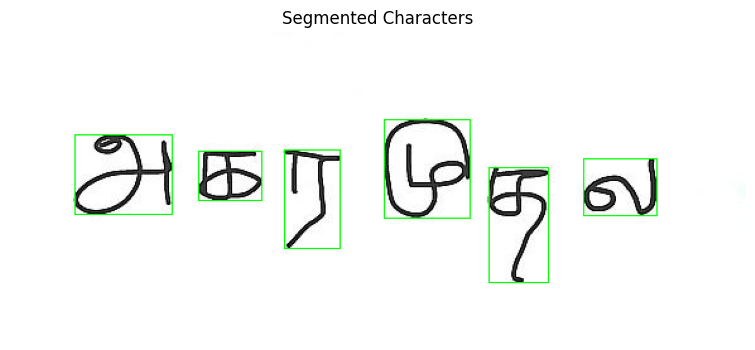

Predicted Tamil Line:

அ க ர முத ல


In [ ]:
image_path = "/content/test7.jpg"
segment_and_predict(image_path, net, transform, classes, device)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Initialize lists for predictions & true labels
all_preds = []
all_labels = []

# Evaluate on Test Data
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


<ipython-input-5-95e4ec292de7>:12: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


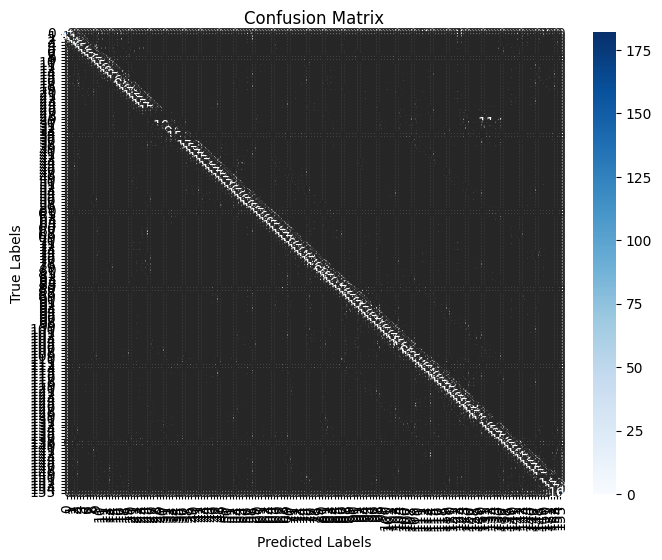

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#  **Classification Report (Precision, Recall, F1-score)**
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))


Classification Report:
               precision    recall  f1-score   support

           அ       0.94      0.96      0.95       182
           ஆ       0.94      0.96      0.95       182
           ஓ       0.92      0.69      0.79       173
          ஙூ       0.99      0.87      0.93       164
          சூ       0.94      0.90      0.92       179
          ஞூ       0.94      0.94      0.94       168
          டூ       0.91      0.84      0.88       174
          ணூ       0.97      0.86      0.92       175
          தூ       0.97      0.95      0.96       182
          நூ       0.88      0.91      0.89       179
          பூ       0.82      0.97      0.89       182
          மூ       0.77      0.86      0.82       182
          யூ       0.98      0.92      0.95       182
           ஃ       0.99      1.00      1.00       182
          ரூ       0.98      0.69      0.81       179
          லூ       0.98      0.97      0.97       180
          வூ       0.90      0.93      0.91       179
   

<ipython-input-53-776823328e6a>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(classes, rotation=45)
<ipython-input-53-776823328e6a>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(classes, rotation=45)
<ipython-input-53-776823328e6a>:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(classes, rotation=45)
<ipython-input-53-776823328e6a>:38: UserWarning: Glyph 2949 (\N{TAMIL LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-53-776823328e6a>:38: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
<ipython-input-53-776823328e6a>:38: UserWarning: Glyph 2950 (\N{TAMIL LETTER AA}) missing from font(s) D

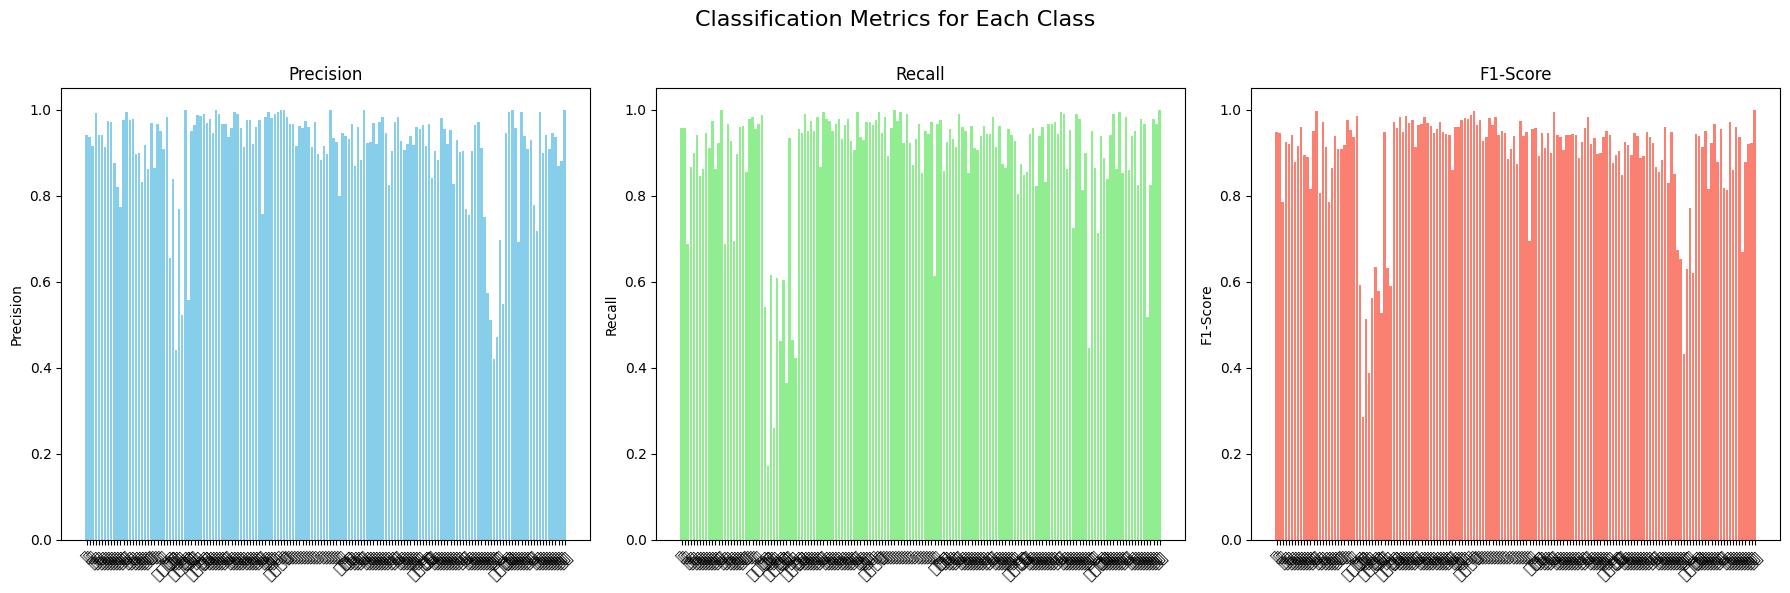

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'all_labels' are the true labels, 'all_preds' are the predicted labels, and 'classes' are the class names
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)

# Extract metrics from the classification report
precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

# Create subplots to display each graph
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision graph
axes[0].bar(classes, precision, color='skyblue')
axes[0].set_title('Precision')
axes[0].set_ylabel('Precision')
axes[0].set_xticklabels(classes, rotation=45)

# Recall graph
axes[1].bar(classes, recall, color='lightgreen')
axes[1].set_title('Recall')
axes[1].set_ylabel('Recall')
axes[1].set_xticklabels(classes, rotation=45)

# F1-Score graph
axes[2].bar(classes, f1_score, color='salmon')
axes[2].set_title('F1-Score')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticklabels(classes, rotation=45)

# Set a general title for the whole figure
fig.suptitle("Classification Metrics for Each Class", fontsize=16)

# Show the plots
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top margin to fit the suptitle
plt.show()


<ipython-input-54-57130e9fff00>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(selected_classes, rotation=45)
<ipython-input-54-57130e9fff00>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(selected_classes, rotation=45)
<ipython-input-54-57130e9fff00>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(selected_classes, rotation=45)
<ipython-input-54-57130e9fff00>:39: UserWarning: Glyph 2949 (\N{TAMIL LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-54-57130e9fff00>:39: UserWarning: Matplotlib currently does not support Tamil natively.
  plt.tight_layout()
<ipython-input-54-57130e9fff00>:39: UserWarning: Glyph 2950 (\N{TAMIL LETTER 

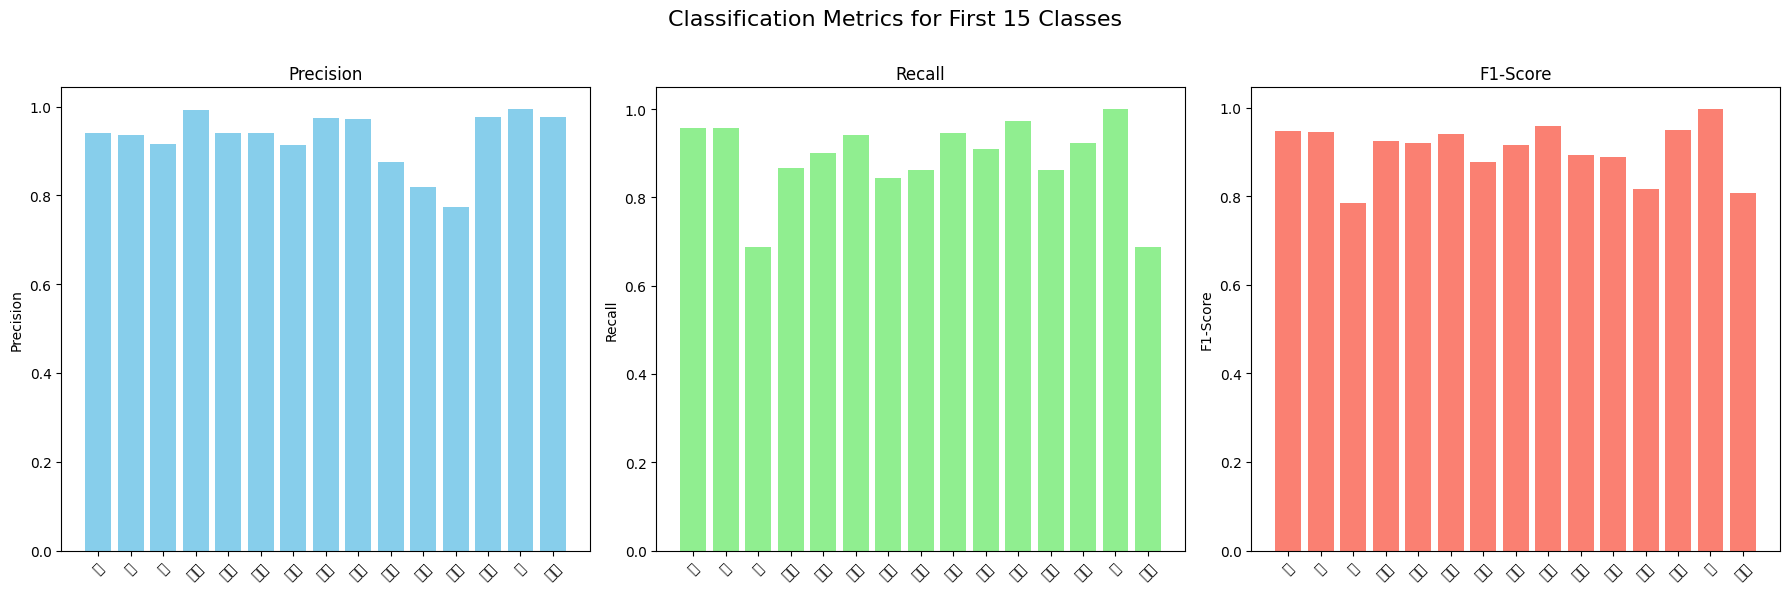

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Assuming 'all_labels' are the true labels, 'all_preds' are the predicted labels, and 'classes' are the class names
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)

# Select only the first 15 classes
selected_classes = classes[:15]
precision = [report[class_name]['precision'] for class_name in selected_classes]
recall = [report[class_name]['recall'] for class_name in selected_classes]
f1_score = [report[class_name]['f1-score'] for class_name in selected_classes]

# Create subplots to display each graph
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision graph
axes[0].bar(selected_classes, precision, color='skyblue')
axes[0].set_title('Precision')
axes[0].set_ylabel('Precision')
axes[0].set_xticklabels(selected_classes, rotation=45)

# Recall graph
axes[1].bar(selected_classes, recall, color='lightgreen')
axes[1].set_title('Recall')
axes[1].set_ylabel('Recall')
axes[1].set_xticklabels(selected_classes, rotation=45)

# F1-Score graph
axes[2].bar(selected_classes, f1_score, color='salmon')
axes[2].set_title('F1-Score')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticklabels(selected_classes, rotation=45)

# Set a general title for the whole figure
fig.suptitle("Classification Metrics for First 15 Classes", fontsize=16)

# Show the plots
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top margin to fit the suptitle
plt.show()


<ipython-input-5-95e4ec292de7>:12: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(arr)


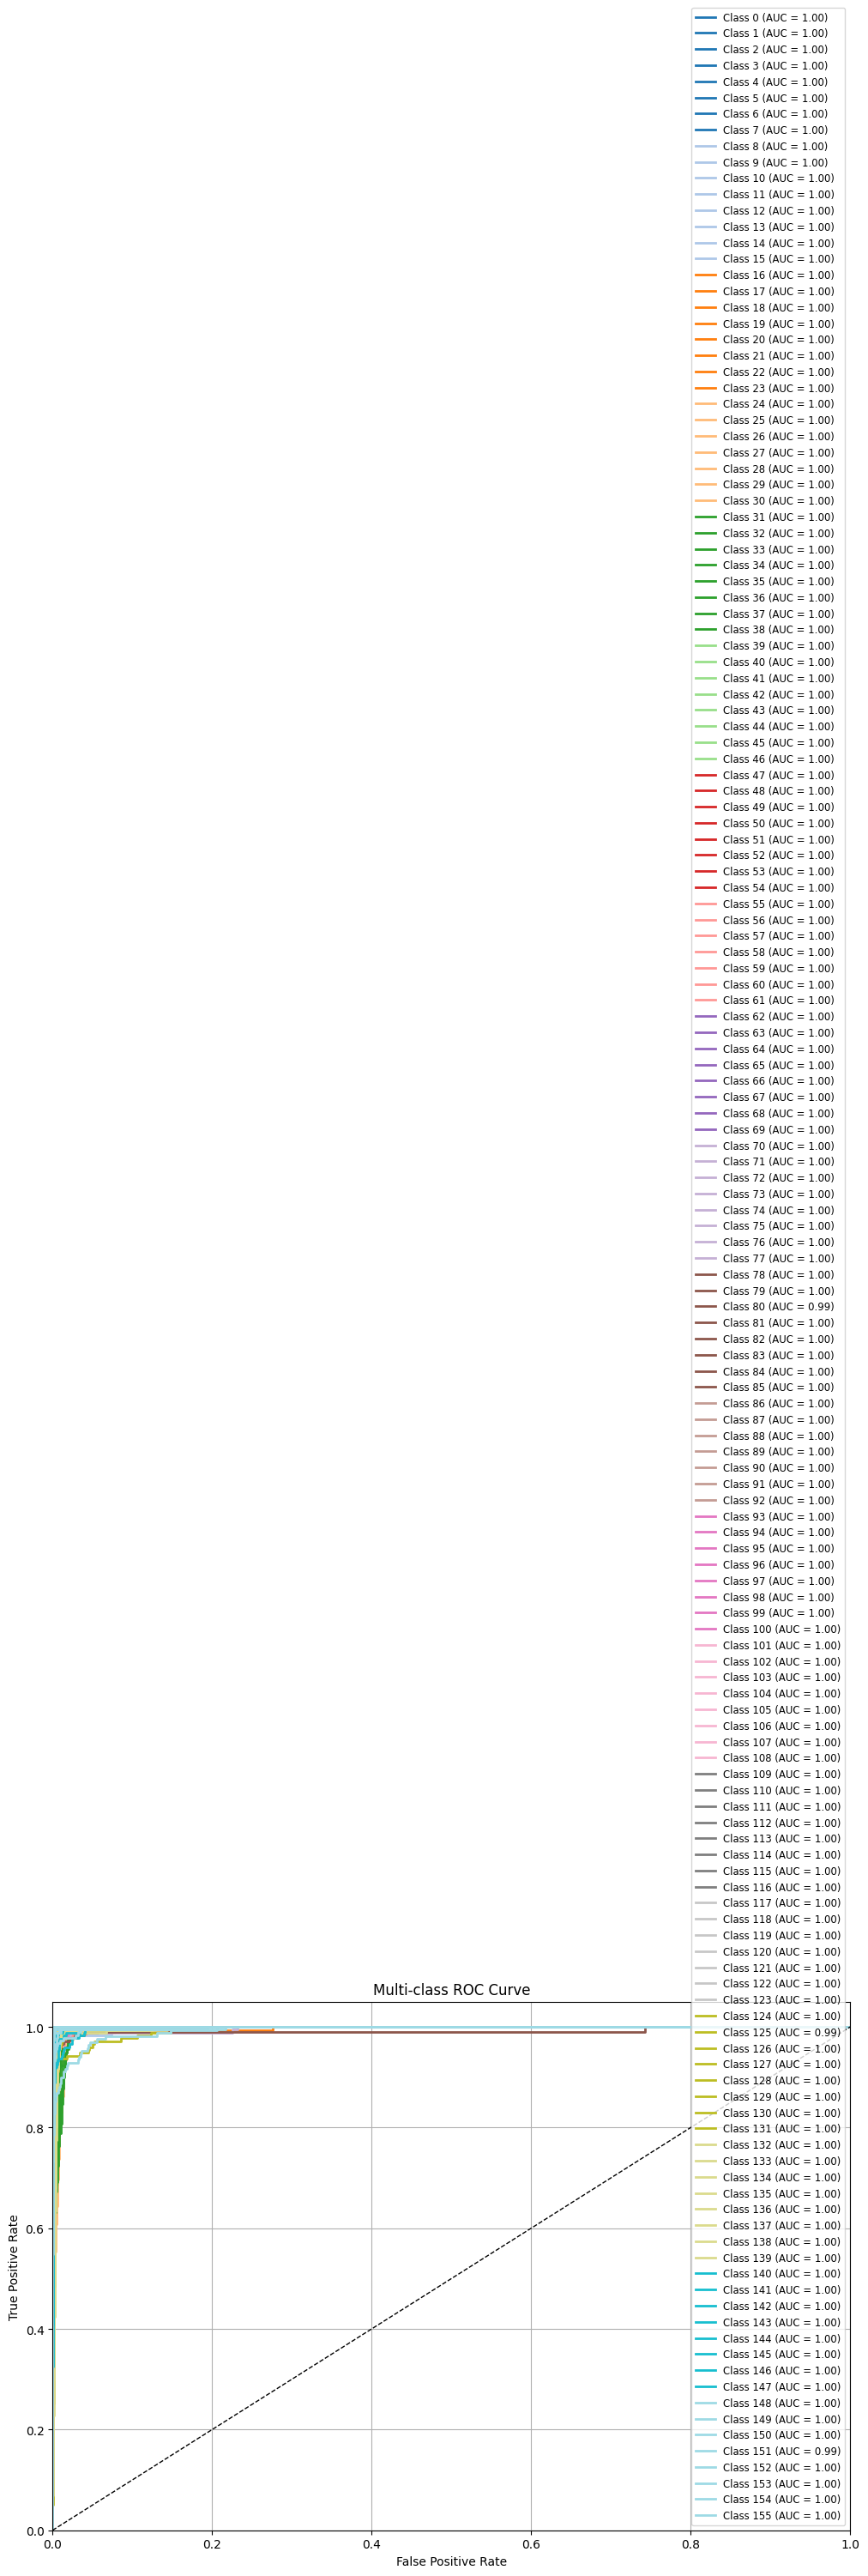

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Get number of classes from your model
num_classes = len(classes)

# Initialize
all_preds = []
all_labels = []
all_probs = []

# Evaluation
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)  # raw logits
        probs = torch.softmax(outputs, dim=1)  # convert to probabilities

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to NumPy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Binarize the labels for ROC computation
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))

# ROC curve & AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, num_classes))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.show()


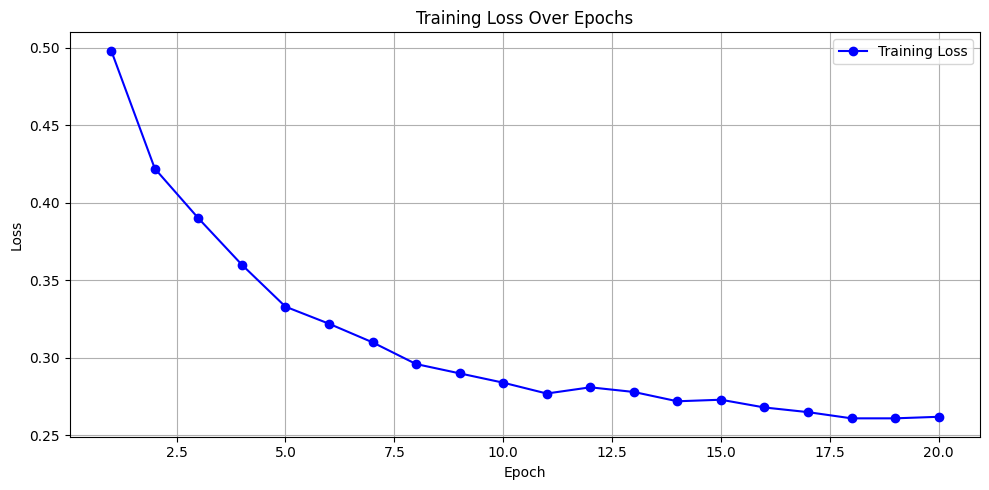

In [ ]:
import matplotlib.pyplot as plt

# Manually entered or parsed average batch losses per epoch from your log
avg_train_loss_per_epoch = [
    0.498,  # Epoch 1
    0.422,  # Epoch 2
    0.390,  # Epoch 3
    0.360,  # Epoch 4
    0.333,  # Epoch 5
    0.322,  # Epoch 6
    0.310,  # Epoch 7
    0.296,  # Epoch 8
    0.290,  # Epoch 9
    0.284,  # Epoch 10
    0.277,  # Epoch 11
    0.281,  # Epoch 12
    0.278,  # Epoch 13
    0.272,  # Epoch 14
    0.273,  # Epoch 15
    0.268,  # Epoch 16
    0.265,  # Epoch 17
    0.261,  # Epoch 18
    0.261,  # Epoch 19
    0.262   # Epoch 20
]

epochs = range(1, 21)

plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss_per_epoch, marker='o', linestyle='-', color='blue', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
